## Canadian Fire Weather Index

*Theodore Keeping*

**Adapted from: (with comments and debugging)**

Wang, Y., Anderson, K.R. and Suddaby, R.M., 2015. *Updated source code for calculating fire danger indices in the Canadian Forest Fire Weather Index System.*


"Daily inputs to the system consist of temperature (°C), relative humidity (%), wind speed (km/h), and precipitation mm) over the past 24 hours"

### FWI main body

In [10]:
import math

In [28]:
class FWICLASS:
    
    # ********* new function **********
    # Defining some attributes of the FWICLASS
    def __init__(self,temp,rhum,wind,prcp):
        self.h = rhum    # Relative humidity
        self.t = temp    # Temperature
        self.w = wind    # Wind
        self.p = prcp    # Precipitation

    
    
    
    # ********* new function **********    
    # Calculating the fine fuel moisture code (FFMC)
    # mo = FFMC on previous day
    # ffmc0 = FFMC as records begin
    # rf = Effective rain fall for calculating FFMC
    # m = Fine Fuel Moisture Content after drying
    # k1 = Intermediate step in calculation of kw
    # kw = Natural log wetting rate, ln (M)/day 
    def FFMCcalc(self,ffmc0):
        mo = (147.2*(101.0 - ffmc0))/(59.5 + ffmc0) #*Eq. 1*#
        if (self.p > 0.5):
            rf = self.p - 0.5 #*Eq. 2*#
            if(mo > 150.0):
                mo = (mo+42.5*rf*math.exp(-100.0/(251.0-mo))*(1.0 - math.exp(-6.93/rf))) + (.0015*(mo - 150.0)**2)*math.sqrt(rf) #*Eq. 3b*#
            elif mo <= 150.0:
                mo = mo+42.5*rf*math.exp(-100.0/(251.0-mo))*(1.0 - math.exp(- 6.93/rf)) #*Eq. 3a*#
            if(mo > 250.0):
                mo = 250.0 
            
    
        # Fine Fuel equilibrium moisture content(EMC) for drying 
        ed = .942*(self.h**.679) + (11.0*math.exp((self.h-100.0)/10.0))+0.18*(21.1-self.t)*(1.0 - 1.0/math.exp(.1150 * self.h)) #*Eq. 4*#

        # Defining m (Fine Fuel Moisture Content after drying )
        if(mo < ed):
            ew = .618*(self.h**.753) + (10.0*math.exp((self.h-100.0)/10.0)) + .18*(21.1-self.t)*(1.0 - 1.0/math.exp(.115 * self.h)) #*Eq. 5*#
            if(mo <= ew):
                kl = .424*(1.0-((100.0-self.h)/100.0)**1.7)+(.0694*math.sqrt(self.w))*(1.0 - ((100.0 - self.h)/100.0)**8) #*Eq. 7a*#
                kw = kl * (.581 * math.exp(.0365 * self.t)) #*Eq. 7b*#
                m = ew - (ew - mo)/10.0**kw #*Eq. 9*#
            elif mo > ew:
                m = mo

        elif(mo == ed):
            m = mo

        elif mo > ed:
            kl =.424*(1.0-(self.h/100.0)**1.7)+(.0694*math.sqrt(self.w))*(1.0-(self.h/100.0)**8) #*Eq. 6a*#
            kw = kl * (.581*math.exp(.0365*self.t)) #*Eq. 6b*#
            m = ed + (mo-ed)/10.0 ** kw #*Eq. 8*#

        # Calculating ffmc output    
        ffmc = (59.5 * (250.0 -m)) / (147.2 + m) #*Eq. 10*#
        if (ffmc > 101.0):
            ffmc = 101.0
        if (ffmc <= 0.0):
            ffmc = 0.0
        return ffmc
    
    
    
    
    
    # ********* new function **********    
    # Calculating duff moisture code (DMC)
    # el = Effective day length in DMC, monthly (FOR CANADA)
    # rk = Log drying rate in DMC, ln (M)/day
    # t = temperature
    # wmi = Duff Moisture Content from previous day
    # wmr = Duff moisture content after rain
    # pr  = DMC after rain
    # dmc0 = 6.0 (constant)
    # mth = month
    def DMCcalc(self,dmc0,mth):
        el = [8.5,10.0,12.0,14.0,15.5,16.5,16.0,14.5,12.5,10.5,9.0,8.0] # hard coded here for canada
        t = self.t
        if (t < -1.1):
            t = -1.1
        rk = 1.894*(t+1.1) * (100.0-self.h) * (el[mth-1]*0.0001) #*Eqs. 16 and 17*#
        if self.p > 1.5:
            ra= self.p
            rw = 0.92*ra - 1.27   #*Eq. 11*#
            wmi = 20.0 + 280.0/math.exp(0.023*dmc0) #*Eq. 12*#
            if dmc0 <= 33.0:
                b = 100.0 /(0.5 + 0.3*dmc0) #*Eq. 13a*#
            elif dmc0 > 33.0:
                if dmc0 <= 65.0:
                    b = 14.0 - 1.3*math.log(dmc0) #*Eq. 13c*#
                elif dmc0 > 65.0:
                    b = 6.2 * math.log(dmc0) - 17.2 #*Eq. 13b*#
            wmr = wmi + (1000*rw) / (48.77+b*rw)   #*Eq. 14*#
            pr = 43.43 * (5.6348 - math.log(wmr-20.0))  #*Eq. 15*#
        elif self.p <= 1.5:
            pr = dmc0
        if (pr<0.0):
            pr = 0.0
        dmc = pr + rk
        if(dmc<= 1.0):
            dmc = 1.0
        return dmc
    

    
    
    
    # ********* new function **********   
    # Calculating drought code:
    # fl = day length adjustment for drought code
    # t = temp
    # pe = Potential evapotranspiration, units of 0.254 mm water/day 
    # mth = month
    # ra = rainfall
    # rw = effective rainfall for drought code calculation
    # smi = Moisture equivalent of previous day’s DC
    # dr = DC after rain
    # dc0 = input constant (15.0)
    def DCcalc(self,dc0,mth):
        fl = [-1.6, -1.6, -1.6, 0.9, 3.8, 5.8, 6.4, 5.0, 2.4, 0.4, -1.6, -1.6]
        t = self.t
        if(t < -2.8):
            t = -2.8
        pe = (0.36*(t+2.8) + fl[mth-1] )/2    #*Eq. 22*# I think this is a linearisation of the Thornthwaite equation???
        if pe <= 0.0:
            pe = 0.0
        if (self.p > 2.8):
            ra = self.p
            rw = 0.83*ra - 1.27 #*Eq. 18*#
            smi = 800.0 * math.exp(-dc0/400.0) #*Eq. 19*#
            dr = dc0 - 400.0*math.log( 1.0+((3.937*rw)/smi) ) #*Eqs. 20 and 21*#
            if (dr > 0.0):
                dc = dr + pe
            else:
                dc = pe
        elif self.p <= 2.8:
            dc = dc0 + pe
        return dc

    
    
    
    
    # ********* new function **********
    # Calculating Initial Spread Index (ISI)
    # mo = FFMC on previous day
    # ff = Fine fuel moisture function
    def ISIcalc(self,ffmc):
        mo = 147.2*(101.0-ffmc) / (59.5+ffmc)     #*Eq. 1*#
        ff = 19.115*math.exp(mo*-0.1386) * (1.0+(mo**5.31)/49300000.0)     #*Eq. 25*#
        isi = ff * math.exp(0.05039*self.w)    #*Eq. 26*#
        return isi






    # ********* new function **********
    # Calculating build-up index (BUI)
    # dc = drought code
    # dmc = duff moisute code
    def BUIcalc(self,dmc,dc):
        if dmc <= 0.4*dc:
            bui = (0.8*dc*dmc) / (dmc+0.4*dc)     #*Eq. 27a*#
        else:
            bui = dmc-(1.0-0.8*dc/(dmc+0.4*dc))*(0.92+(0.0114*dmc)**1.7)    #*Eq. 27b*#
        if bui <0.0:
            bui = 0.0
        return bui





    # ********* new function **********
    # Calculating fire weather index (FWI)
    # bb = Intermediate FWI
    def FWIcalc(self,isi,bui):
        if bui <= 80.0:
            bb = 0.1 * isi * (0.626*bui**0.809 + 2.0)        #*Eq. 28a*#
        else:
            bb = 0.1*isi*(1000.0/(25. + 108.64/math.exp(0.023*bui)))        #*Eq. 28b*#
        if(bb <= 1.0):
            fwi = bb        #*Eq. 30b*#
        else:
            fwi = math.exp(2.72 * (0.434*math.log(bb))**0.647)        #*Eq. 30a*#
        return fwi

In [12]:
def FWI_calculate(infile_name):
    ffmc0 = 85.0
    dmc0 = 6.0
    dc0 = 15.0
    infile = open(infile_name,'r') #space gapped text file
    outfile = open('fwioutput.txt','w')
    
    try:
        for line in infile:
            mth,day,temp,rhum,wind,prcp=[float(field) for field in line.strip().lstrip('[').rstrip(']').split()]
            if rhum > 100.0:
                rhum = 100.0
            mth = int(mth)
            #print(temp,rhum,wind,prcp)
            fwisystem = FWICLASS(temp,rhum,wind,prcp)
            ffmc = fwisystem.FFMCcalc(ffmc0)     
            dmc  = fwisystem.DMCcalc(dmc0,mth)
            dc   = fwisystem.DCcalc(dc0,mth)
            isi  = fwisystem.ISIcalc(ffmc)
            bui  = fwisystem.BUIcalc(dmc,dc) 
            fwi  = fwisystem.FWIcalc(isi,bui)
            ffmc0 = ffmc
            dmc0 = dmc
            dc0 = dc
            outfile.write('%s %s %s %s %s %s %s %s %s %s %s %s\n'%(str(mth),str(day),str(temp),str(rhum),str(wind),str(prcp),str(round(ffmc,1)),str(round(dmc,1)),str(round(dc,1)),str(round(isi,1)),str(round(bui,1)),str(round(fwi,1))))
    finally:
        infile.close()
        outfile.close()

## The FWI code - including loading data

In terminal type:

    ln -s /shared/groups/jrole001/geog0121/UKCP18 $HOME/UKCP18
    conda config –add envs_dirs /shared/groups/jrole001/geog0121/env

## Running the whole timeseries

In [13]:
import xarray
import numpy as np
import matplotlib.pyplot as plt

In [14]:
year_start = 1980
year_step = 10
no_steps = 10

In [15]:
UK_data = np.zeros((4,3600*10,112, 82))

for i in range(no_steps):
    yr = year_start + year_step*i

    hurs_file = f'~/UKCP18/day/hurs_rcp85_land-rcm_uk_12km_01_day_{yr}1201-{yr + year_step}1130.nc'
    tas_file = f'~/UKCP18/day/tas_rcp85_land-rcm_uk_12km_01_day_{yr}1201-{yr + year_step}1130.nc'
    wind_file = f'~/UKCP18/day/sfcWind_rcp85_land-rcm_uk_12km_01_day_{yr}1201-{yr + year_step}1130.nc'
    pr_file = f'~/UKCP18/day/pr_rcp85_land-rcm_uk_12km_01_day_{yr}1201-{yr + year_step}1130.nc'
    
    tas = xarray.open_dataset(tas_file)
    UK_data[0,i*3600:(i+1)*3600,:,:] = np.array(tas.tas[0,:,:,:])

    hurs = xarray.open_dataset(hurs_file)
    UK_data[1,i*3600:(i+1)*3600,:,:] = np.array(hurs.hurs[0,:,:,:])
    
    wind = xarray.open_dataset(wind_file)
    UK_data[2,i*3600:(i+1)*3600,:,:] = np.array(wind.sfcWind[0,:,:,:])*3.6 # converting from m/s to km/hr
    
    pr = xarray.open_dataset(pr_file)
    UK_data[3,i*3600:(i+1)*3600,:,:] = np.array(pr.pr[0,:,:,:])

In [29]:
def FWI_calc(UK_data):
    # Starting parameters:
    # Defining output array:
    #outputs = np.zeros((7,UK_data.shape[1],UK_data.shape[2],UK_data.shape[3]))
    # Slimmed down outputs:
    outputs = np.zeros((1,UK_data.shape[1],UK_data.shape[2],UK_data.shape[3]))
    # Getting variables: mth,temp,rhum,wind,prcp
    print(f'Total number of steps: {UK_data.shape[3]}')
    for k in range(UK_data.shape[3]):
        print(f'Step {k}')
        for j in range(UK_data.shape[2]):
            ffmc0 = 85.0
            dmc0 = 6.0
            dc0 = 15.0
            for i in range(UK_data.shape[1]):
                # Getting month (Dec-Nov year structure)
                mth  = int(((i-i%30)/30 - 1)%12 + 1)
                temp = UK_data[0,i,j,k]
                rhum = UK_data[1,i,j,k]
                wind = UK_data[2,i,j,k]
                prcp = UK_data[3,i,j,k]
                
                if rhum > 100.0:
                    rhum = 100.0
                fwisystem = FWICLASS(temp,rhum,wind,prcp)
                ffmc = fwisystem.FFMCcalc(ffmc0)     
                dmc  = fwisystem.DMCcalc(dmc0,mth)
                dc   = fwisystem.DCcalc(dc0,mth)
                isi  = fwisystem.ISIcalc(ffmc)
                bui  = fwisystem.BUIcalc(dmc,dc) 
                fwi  = fwisystem.FWIcalc(isi,bui)
                ffmc0 = ffmc
                dmc0 = dmc
                dc0 = dc
                #print(mth,temp,rhum,wind,prcp,ffmc,dmc,dc,isi,bui,fwi)
                #outputs[:,i,j,k] = mth,ffmc,dmc,dc,isi,bui,fwi
                outputs[:,i,j,k] = fwi
                
    return outputs

In [30]:
outputs = FWI_calc(UK_data)

Total number of steps: 82
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81


(1, 36000, 112, 82)
(4, 36000, 112, 82)


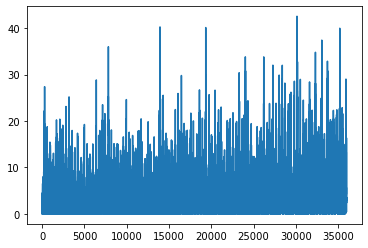

In [32]:
print(outputs.shape)
print(UK_data.shape)
plt.plot(outputs[0,:,38,76])

In [33]:
FWI_UK_data = np.concatenate((UK_data,outputs),axis = 0)
print(FWI_UK_data.shape)

(5, 36000, 112, 82)


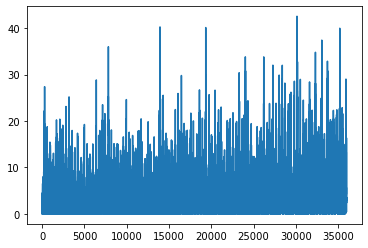

In [34]:
plt.plot(FWI_UK_data[4,:,38,76])

In [36]:
np.save("UK_FWI.npy", FWI_UK_data)

In [ ]:
#!chmod 644 filename

## Testing

In [26]:
def FWI_calc(UK_data,months):
    # Starting parameters:
    # Defining output array:
    #outputs = np.zeros((7,UK_data.shape[1],UK_data.shape[2],UK_data.shape[3]))
    # Slimmed down outputs:
    outputs = np.zeros((1,UK_data.shape[1],UK_data.shape[2],UK_data.shape[3]))
    # Getting variables: mth,temp,rhum,wind,prcp
    print(f'Total number of steps: {UK_data.shape[3]}')
    for k in range(UK_data.shape[3]):
        print(f'Step {k}')
        for j in range(UK_data.shape[2]):
            ffmc0 = 85.0
            dmc0 = 6.0
            dc0 = 15.0
            for i in range(UK_data.shape[1]):
                # Getting month (Dec-Nov year structure)
                #mth  = int(((i-i%30)/30 - 1)%12 + 1)
                mth = int(months[i])
                temp = UK_data[0,i,j,k]
                rhum = UK_data[1,i,j,k]
                wind = UK_data[2,i,j,k]
                prcp = UK_data[3,i,j,k]
                
                if rhum > 100.0:
                    rhum = 100.0
                fwisystem = FWICLASS(temp,rhum,wind,prcp)
                ffmc = fwisystem.FFMCcalc(ffmc0)     
                dmc  = fwisystem.DMCcalc(dmc0,mth)
                dc   = fwisystem.DCcalc(dc0,mth)
                isi  = fwisystem.ISIcalc(ffmc)
                bui  = fwisystem.BUIcalc(dmc,dc) 
                fwi  = fwisystem.FWIcalc(isi,bui)
                ffmc0 = ffmc
                dmc0 = dmc
                dc0 = dc
                #print(mth,temp,rhum,wind,prcp,ffmc,dmc,dc,isi,bui,fwi)
                #outputs[:,i,j,k] = mth,ffmc,dmc,dc,isi,bui,fwi
                outputs[:,i,j,k] = fwi
                
    return outputs

In [27]:
# Set el = [6.5,7.5,9.0,12.8,13.9,13.9,12.4,10.9,9.4,8.0,7.0,6.0] in FWICLASS
# as Canadian test data

test_data = np.loadtxt('test_data.txt')

in_data = np.zeros((4,49,1,1))
in_data[0,:,0,0] = test_data[:,2]
in_data[1,:,0,0] = test_data[:,3]
in_data[2,:,0,0] = test_data[:,4]
in_data[3,:,0,0] = test_data[:,5]
months = test_data[:,0]

out_data = FWI_calc(in_data,months)
fwi_test = test_data[:,11]

print(np.around(out_data[0,:,0,0],1) - fwi_test)

Total number of steps: 1
Step 0
[0.1 0.2 0.2 0.2 0.5 0.4 0.2 0.3 0.4 0.  0.  0.  0.  0.2 0.5 0.6 0.7 0.6
 0.4 0.4 0.6 1.  1.  1.  2.2 1.2 0.1 0.2 0.3 0.3 0.5 0.7 0.6 0.  0.1 0.3
 0.3 0.5 0.7 0.2 0.9 0.1 0.1 0.1 0.1 0.1 0.2 0.3 0.4]
